# <center> <b> <span style="color: #2f528f">  BANK CUSTOMER DATA ANALYSIS
<center> <span style="color: #eb2d4b; font-family: Babas; font-size: 1.5em;"> <b> Profile customers of the bank and predict who are likely to churn.<br>

<b> <span style="font-family: Babas; font-size: 1.8em;"> Contents
* [Overview](#chapter1)
* [Data Wrangling](#chapter2)
* [Exploratory Data Analysis](#chapter3)
* [Model Development](#chapter4)
* [Conclusion](#chapter5)

## Libraries

pip install xgboost

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 50)  # or 1000

In [3]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline, Pipeline
from imblearn.under_sampling import NearMiss

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve, RocCurveDisplay)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

## 1. Overview <a class="anchor" id="chapter1"></a>

#### About the dataset:
The dataset is derived from the actual database of a leading commercial bank in Vietnam, and it contains information on history of payments, transactions, demographic factors and preferences of customers:
- <b> Demographic information </b>: gender, marital status, address, year of birth.
- <b> History of payments and transactions </b>: total amount, max amount, min amount, payment code, transaction type, number of receivers in a week, a month and 3 months...

#### Target: Customer Churn - <i>A Self-defined feature</i>
- We'll consider customers who did not make any payments or transactions in <b> 1 month </b> as churn customers.
- How to create "Churn" variable: fill all NaN values in <b> "total_act_juin2021" </b> with 0, which means there was no transaction was made in June 2021 => These are churn customers. 

#### First look at the data

In [4]:
df = pd.read_csv('./data/bankcustomerchurn.csv')
df

,gender,marital_status,resid_province,resid_district,resid_wards,birth_incorp_date,amount_week,max_amount_week,min_amount_week,distinct_payment_code_week,count_payment_code_week,distinct_trans_group_week,distinct_ref_no_week,amount_month,max_amount_month,min_amount_month,distinct_payment_code_month,count_payment_code_month,distinct_trans_group_month,distinct_ref_no_month,amount_3month,max_amount_3month,min_amount_3month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,distinct_ref_no_3month,most_act_mar2021_count,most_act_mar2021,total_act_mar2021,total_amt_mar2021,most_act_juin2021_count,most_act_juin2021,total_act_juin2021,total_amt_juin2021
0,MALE,Married,27.0,262.0,9436.0,1992.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.000056,0.000204,0.000008,0.0,0.0,2.0,12.0,0.000073,0.000400,5.920000e-06,0,0,2,33,5.0,Giao dich chuyen khoan,5.0,0.000016,14.0,Giao dich chuyen khoan,17.0,0.006543
1,MALE,Single,79.0,769.0,27097.0,1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,0.000140,0.000203,0.0,0.0,1.0,1.0,0.000014,0.000068,1.103180e-04,0,0,2,5,NaN,NaN,NaN,NaN,1.0,Giao dich thanh toan,1.0,0.000062
2,MALE,Married,1.0,250.0,8989.0,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000030,0.000122,0.000143,0.0,0.0,1.0,2.0,0.000016,0.000060,2.100000e-05,2,3,2,7,4.0,Giao dich chuyen khoan,6.0,0.000046,1.0,Giao dich chuyen khoan,2.0,0.000071
3,MALE,Single,40.0,431.0,18055.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MALE,Married,49.0,512.0,20758.0,1989.0,0.0,0.000114,0.000636,0.0,0.0,1.0,1.0,0.000097,0.000247,0.000001,1.0,5.0,3.0,12.0,0.000074,0.000380,5.920000e-07,1,11,3,24,9.0,Giao dich chuyen khoan,10.0,0.000170,17.0,Giao dich chuyen khoan,19.0,0.000575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,FEMALE,Single,1.0,6.0,178.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2,16.0,Giao dich chuyen khoan,18.0,0.000108,15.0,Giao dich chuyen khoan,16.0,0.000351
99996,MALE,Single,25.0,239.0,8689.0,2001.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0,0,1,1,NaN,NaN,NaN,NaN,8.0,GIAO DICH PHI TAI CHINH,15.0,0.000116
99997,FEMALE,Married,31.0,316.0,11842.0,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000046,0.000333,0.000482,0.0,0.0,2.0,2.0,0.000012,0.000163,5.150000e-05,0,0,2,4,5.0,Giao dich chuyen khoan,9.0,0.000436,2.0,Giao dich chuyen khoan,3.0,0.000170
99998,MALE,Single,1.0,271.0,9706.0,2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,29.0,Giao dich chuyen khoan,36.0,0.000090,12.0,Giao dich chuyen khoan,13.0,0.000143


## 2. Data Wrangling <a class="anchor" id="chapter2"></a>

### 2.1. General.

#### Data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        97266 non-null   object 
 1   marital_status                96971 non-null   object 
 2   resid_province                93431 non-null   float64
 3   resid_district                93435 non-null   float64
 4   resid_wards                   93433 non-null   float64
 5   birth_incorp_date             99990 non-null   float64
 6    amount_week                  54800 non-null   float64
 7   max_amount_week               54800 non-null   float64
 8   min_amount_week               54800 non-null   float64
 9   distinct_payment_code_week    56850 non-null   float64
 10  count_payment_code_week       56850 non-null   float64
 11  distinct_trans_group_week     56850 non-null   float64
 12  distinct_ref_no_week          56850 non-null 

In [7]:
df.astype({'distinct_payment_code_week': 'str'})
df.astype({'distinct_trans_group_week': 'str'})
df.astype({'distinct_payment_code_month': 'str'})
df.astype({'distinct_trans_group_month': 'str'})
df.astype({'distinct_payment_code_3month': 'str'})
df.astype({'distinct_trans_group_3month': 'str'})

,gender,marital_status,resid_province,resid_district,resid_wards,birth_incorp_date,amount_week,max_amount_week,min_amount_week,distinct_payment_code_week,count_payment_code_week,distinct_trans_group_week,distinct_ref_no_week,amount_month,max_amount_month,min_amount_month,distinct_payment_code_month,count_payment_code_month,distinct_trans_group_month,distinct_ref_no_month,amount_3month,max_amount_3month,min_amount_3month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,distinct_ref_no_3month,most_act_mar2021_count,most_act_mar2021,total_act_mar2021,total_amt_mar2021,most_act_juin2021_count,most_act_juin2021,total_act_juin2021,total_amt_juin2021
0,MALE,Married,27.0,262.0,9436.0,1992.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.000056,0.000204,0.000008,0.0,0.0,2.0,12.0,0.000073,0.000400,5.920000e-06,0,0,2,33,5.0,Giao dich chuyen khoan,5.0,0.000016,14.0,Giao dich chuyen khoan,17.0,0.006543
1,MALE,Single,79.0,769.0,27097.0,1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,0.000140,0.000203,0.0,0.0,1.0,1.0,0.000014,0.000068,1.103180e-04,0,0,2,5,NaN,NaN,NaN,NaN,1.0,Giao dich thanh toan,1.0,0.000062
2,MALE,Married,1.0,250.0,8989.0,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000030,0.000122,0.000143,0.0,0.0,1.0,2.0,0.000016,0.000060,2.100000e-05,2,3,2,7,4.0,Giao dich chuyen khoan,6.0,0.000046,1.0,Giao dich chuyen khoan,2.0,0.000071
3,MALE,Single,40.0,431.0,18055.0,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MALE,Married,49.0,512.0,20758.0,1989.0,0.0,0.000114,0.000636,0.0,0.0,1.0,1.0,0.000097,0.000247,0.000001,1.0,5.0,3.0,12.0,0.000074,0.000380,5.920000e-07,1,11,3,24,9.0,Giao dich chuyen khoan,10.0,0.000170,17.0,Giao dich chuyen khoan,19.0,0.000575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,FEMALE,Single,1.0,6.0,178.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2,16.0,Giao dich chuyen khoan,18.0,0.000108,15.0,Giao dich chuyen khoan,16.0,0.000351
99996,MALE,Single,25.0,239.0,8689.0,2001.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0,0,1,1,NaN,NaN,NaN,NaN,8.0,GIAO DICH PHI TAI CHINH,15.0,0.000116
99997,FEMALE,Married,31.0,316.0,11842.0,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000046,0.000333,0.000482,0.0,0.0,2.0,2.0,0.000012,0.000163,5.150000e-05,0,0,2,4,5.0,Giao dich chuyen khoan,9.0,0.000436,2.0,Giao dich chuyen khoan,3.0,0.000170
99998,MALE,Single,1.0,271.0,9706.0,2002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,29.0,Giao dich chuyen khoan,36.0,0.000090,12.0,Giao dich chuyen khoan,13.0,0.000143


#### Missing values

In [8]:
round(df.isna().sum()/len(df)*100,2).sort_values(ascending=False)

max_amount_week                 45.20
min_amount_week                 45.20
 amount_week                    45.20
distinct_payment_code_week      43.15
distinct_ref_no_week            43.15
distinct_trans_group_week       43.15
count_payment_code_week         43.15
total_amt_juin2021              29.34
most_act_juin2021_count         28.62
most_act_juin2021               28.62
total_act_juin2021              28.62
 total_amt_mar2021              27.15
total_act_mar2021               26.52
most_act_mar2021                26.52
most_act_mar2021_count          26.52
amount_month                    23.00
max_amount_month                23.00
min_amount_month                23.00
distinct_ref_no_month           17.78
count_payment_code_month        17.78
distinct_trans_group_month      17.78
distinct_payment_code_month     17.78
amount_3month                   13.48
max_amount_3month               13.48
min_amount_3month               13.48
resid_wards                      6.57
resid_provin

#### <u>Comment</u>:
In this 100000-row dataset, most columns contain missing values. <br>
There are 7 features whose missing values make up more than 30%.

#### Rename columns and values in columns

In [9]:
df.rename(columns = {' amount_week ':'amount_week', ' total_amt_mar2021 ': 'total_amt_mar2021'}, inplace = True)

In [10]:
# Rename value in Gender column
df['gender'].replace('FEMALE', 'Female',inplace=True)
df['gender'].replace('MALE', 'Male',inplace=True)

In [11]:
# Rename value in most_act columns
df['most_act_mar2021'].replace('GIAO DICH PHI TAI CHINH', 'Giao dich phi tai chinh',inplace=True)
df['most_act_mar2021'].replace('GIAO DICH RUT TIEN ATM', 'Giao dich rut tien ATM',inplace=True)
df['most_act_mar2021'].replace('GIAO DICH TIET KIEM', 'Giao dich tiet kiem',inplace=True)
df['most_act_mar2021'].replace('GIAO DICH THANH TOAN', 'Giao dich thanh toan',inplace=True)

df['most_act_juin2021'].replace('GIAO DICH PHI TAI CHINH', 'Giao dich phi tai chinh',inplace=True)
df['most_act_juin2021'].replace('GIAO DICH RUT TIEN ATM', 'Giao dich rut tien ATM',inplace=True)
df['most_act_juin2021'].replace('GIAO DICH TIET KIEM', 'Giao dich tiet kiem',inplace=True)
df['most_act_juin2021'].replace('GIAO DICH THANH TOAN', 'Giao dich thanh toan',inplace=True)
df['most_act_juin2021'].replace('GIAO DICH VAY', 'Giao dich vay',inplace=True)

#### Create "Age" column

In [12]:
df['age'] = 2021 - df.birth_incorp_date
df.drop('birth_incorp_date', inplace = True, axis = 1)

#### Create "Churn" column

In [13]:
df['total_act_juin2021'] = df['total_act_juin2021'].fillna(0)
def conditions(df):
    if (df['total_act_juin2021'] == 0):
        return True
    elif(df['total_act_juin2021'] > 0):
        return False
df['Churn'] = df.apply(conditions, axis = 1)

### 2.2. Anomalies detection

In [14]:
df.describe()

,resid_province,resid_district,resid_wards,amount_week,max_amount_week,min_amount_week,distinct_payment_code_week,count_payment_code_week,distinct_trans_group_week,distinct_ref_no_week,amount_month,max_amount_month,min_amount_month,distinct_payment_code_month,count_payment_code_month,distinct_trans_group_month,distinct_ref_no_month,amount_3month,max_amount_3month,min_amount_3month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,distinct_ref_no_3month,most_act_mar2021_count,total_act_mar2021,total_amt_mar2021,most_act_juin2021_count,total_act_juin2021,total_amt_juin2021,age
count,93431.000000,93435.000000,93433.000000,54800.00000,5.480000e+04,54800.000000,56850.000000,56850.000000,56850.000000,56850.000000,7.700000e+04,7.700000e+04,77000.000000,82223.000000,82223.000000,82223.000000,82223.000000,8.652000e+04,8.652000e+04,86520.000000,100000.000000,100000.000000,100000.000000,100000.00000,73477.000000,73477.000000,7.285500e+04,71377.000000,100000.000000,70664.000000,99990.000000
mean,32.143379,339.395291,12481.062130,0.00059,1.223446e-03,0.000669,0.336851,0.577766,1.489921,6.178276,1.238261e-03,1.974828e-03,0.000121,0.744184,1.837539,2.023461,18.274339,6.747963e-04,1.372041e-03,0.000150,0.861720,4.051670,2.431310,40.06861,16.329436,19.152252,1.370018e-03,16.359696,13.844970,0.003563,32.519332
std,29.360372,278.936947,10064.755806,0.00615,6.287416e-03,0.007529,0.526343,2.857005,0.706985,11.763902,7.281018e-03,8.754136e-03,0.004095,0.870959,5.174273,0.979911,41.825200,4.872849e-03,6.238066e-03,0.004568,0.998603,8.794302,1.161273,90.35093,36.292739,37.629618,9.134551e-03,33.845842,31.222076,0.018221,9.474698
min,0.000000,0.000000,0.000000,0.00000,2.040000e-09,0.000000,0.000000,0.000000,1.000000,0.000000,2.800000e-10,2.040000e-09,0.000000,0.000000,0.000000,1.000000,0.000000,6.570000e-11,1.000000e-09,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000,1.100000e-08,1.000000,0.000000,0.000000,1.000000
25%,1.000000,21.000000,637.000000,0.00000,3.060000e-05,0.000011,0.000000,0.000000,1.000000,1.000000,2.400000e-05,8.160000e-05,0.000002,0.000000,0.000000,1.000000,3.000000,1.280000e-05,6.300000e-05,0.000001,0.000000,0.000000,1.000000,4.00000,3.000000,4.000000,2.737600e-05,3.000000,0.000000,0.000084,26.000000
50%,30.000000,298.000000,11077.000000,0.00000,1.551020e-04,0.000045,0.000000,0.000000,1.000000,3.000000,1.017675e-04,3.040205e-04,0.000004,1.000000,1.000000,2.000000,9.000000,5.740000e-05,2.020645e-04,0.000003,1.000000,1.000000,2.000000,17.00000,7.000000,10.000000,1.098480e-04,8.000000,5.000000,0.000319,31.000000
75%,51.000000,532.000000,21385.000000,0.00000,7.297960e-04,0.000182,1.000000,1.000000,2.000000,7.000000,5.404727e-04,1.224490e-03,0.000012,1.000000,3.000000,3.000000,20.000000,2.978360e-04,1.000000e-03,0.000006,1.000000,6.000000,3.000000,45.00000,18.000000,22.000000,5.530240e-04,19.000000,16.000000,0.001555,38.000000
max,96.000000,973.000000,99999.000000,1.00000,1.000000e+00,1.000000,5.000000,331.000000,6.000000,1128.000000,1.000000e+00,1.000000e+00,1.000000,8.000000,390.000000,7.000000,5800.000000,1.000000e+00,1.000000e+00,1.000000,9.000000,1225.000000,7.000000,8106.00000,3321.000000,3328.000000,1.000000e+00,2574.000000,2574.000000,1.000000,948.000000


Through the mean and max of the above variables, we can see that some of them may contain outliers. We use boxplot to confirm whether they have anomalies or not.

#### Age

<AxesSubplot:ylabel='age'>

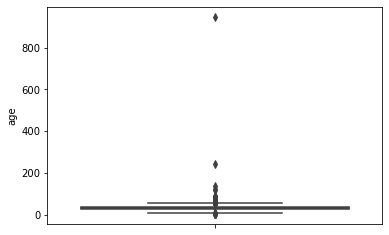

In [15]:
sns.boxplot(y = 'age', data = df)

#### <u>Comment</u>:
As we can see from the table, the lowest age of the customers is 1 year old, while the highest age is 948. It means that there are outliers in this variable. We will remove datapoints in which age > 100 and age < 16 in the next part.

#### Transaction information

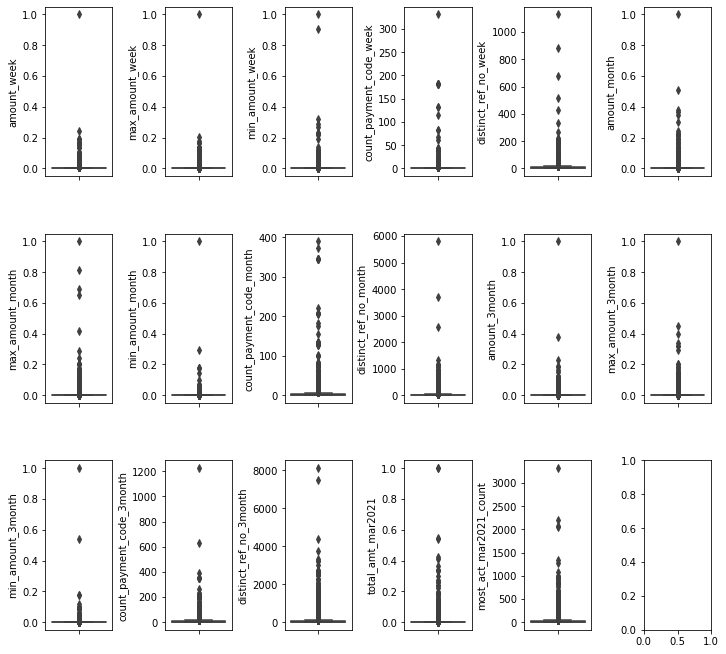

In [16]:
data_num = df.loc[:,['amount_week', 'max_amount_week','min_amount_week','count_payment_code_week', 'distinct_ref_no_week', 
                     'amount_month', 'max_amount_month','min_amount_month','count_payment_code_month', 'distinct_ref_no_month', 
                     'amount_3month', 'max_amount_3month','min_amount_3month','count_payment_code_3month', 'distinct_ref_no_3month',
                     'total_amt_mar2021','most_act_mar2021_count']]

fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(10, 9))
index = 0
axs = axs.flatten()
for k,v in data_num.items():
    sns.boxplot(y=k, data=data_num, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

The graph shows that all these variables have extreme values. 

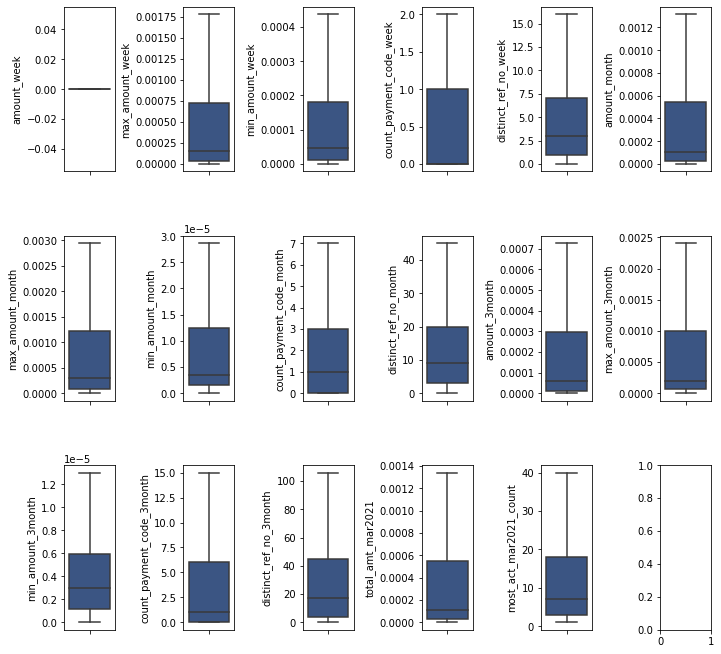

In [17]:
fig, axs = plt.subplots(ncols=6, nrows=3, figsize=(10, 9))
index = 0
axs = axs.flatten()
for k,v in data_num.items():
    sns.boxplot(y=k, data=data_num, ax=axs[index], color = '#2f528f', showfliers = False)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

#### <u>Comment</u>:
This is how the variables look like after removing all the outliers. However, we need to handle with these outliers carefully in order not to remove significant information. As a result, we will not remove outliers in these variables.

## 3. Exploratory Data Analysis <a class="anchor" id="chapter3"></a>

In [18]:
def plotdrawing(feature,x,y):
    plt.figure(figsize=(x,y))
    fig_churn = sns.histplot(data = df, x = feature, hue = 'Churn', discrete=True, multiple="stack", palette = 'RdBu')
    fig_churn.set_ylabel('Number of Customers', fontsize = 13)
    fig_churn.set_xlabel(f'{feature}', fontsize = 13)
    fig_churn.set_title(f'Churn by {feature}', fontsize = 14)
    for c in fig_churn.containers:
        labels = [f'{h/df.Churn.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
        fig_churn.bar_label(c, labels=labels, label_type='edge')

In [19]:
def percentsum(feature):
    des = df.groupby([feature])['Churn'].agg(['count', 'sum', 'mean']) 
    des = des.rename(columns = {'count':'TotalCustumers', 'sum':'ChurnQuantity', 'mean':'ChurnRate'}) 
    return des

In [20]:
def pdraw(feature,x,y):
    plt.figure(figsize=(x,y))
    fig_churn = sns.countplot(x=feature, hue='Churn', data = df, palette='RdBu')
    fig_churn.bar_label(fig_churn.containers[0])
    fig_churn.bar_label(fig_churn.containers[1])
    print(df[feature].value_counts(normalize = True))

### 3.1. Churn Visualization. 

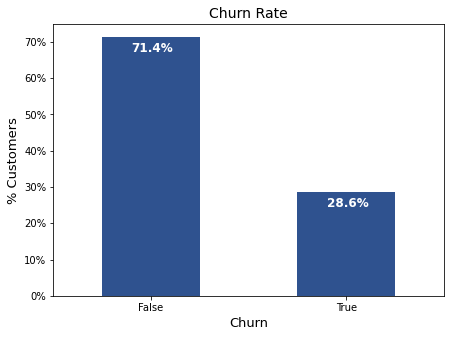

In [21]:
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar', stacked = True, rot = 0, color = '#2f528f', figsize = (7,5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers', fontsize = 13)
ax.set_xlabel('Churn', fontsize = 13)
ax.set_title('Churn Rate', fontsize = 14)

totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%', fontsize=12, color='white', weight = 'bold')

#### <u>Comment</u>: 
In this dataset, <b> 71.4% </b> of the customers do not churn. As a result, the data is skewed , and our modelling with skeweness could lead to a lot of false negatives. We will use oversampling method to avoid skewness in the modeling section later.

### 3.2. Customer Information.
#### 3.2.1. Churn by gender and marital status.

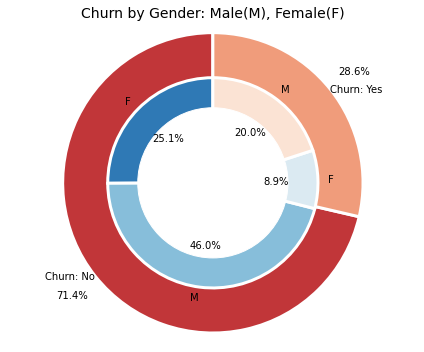

In [22]:
plt.figure(figsize=(6, 5))
palette_color = sns.color_palette('RdBu')
labels =['Churn: No', 'Churn: Yes']
values = df['Churn'].value_counts()
labels_gender = ['F', 'M', 'F', 'M']
values_gender = df.groupby(['Churn', 'gender'])['gender'].value_counts()
width = 3
plt.pie(values, autopct='%1.1f%%', 
       colors=palette_color, labels=labels, radius=10, startangle=90, pctdistance=1.2, labeldistance=1.0,
       wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.pie(values_gender, labels=labels_gender, autopct='%1.1f%%',
       colors=sns.color_palette('RdBu_r'), radius=10 - width, startangle=90,
       wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

centre_circle = plt.Circle((0,0),5,color='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn by Gender: Male(M), Female(F)', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

#### <u>Comment</u>:
- As it can be seen from the donut plot, <b> 28.6% </b> of customers have switched to another bank (churned). <br>
- Among the customers who has churned, the churn rate of males is much higher than females. This can be explained that the number of male customers in this dataset is more than the number of female customers, so the male leaving rate is also higher. However, men and women's behaviors may vary in deciding to continue or stop using bank service.

Single       0.560982
Married      0.434419
Other        0.003743
Partner      0.000392
Divorced     0.000340
Widow        0.000082
Seperated    0.000041
Name: marital_status, dtype: float64


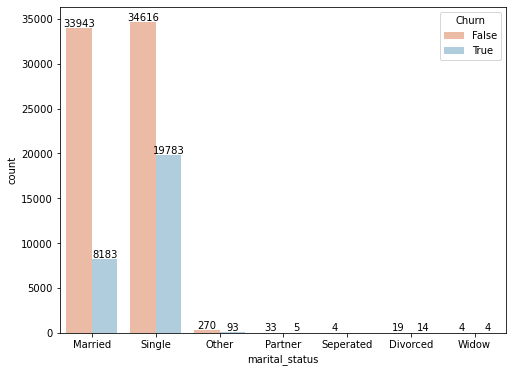

In [23]:
pdraw('marital_status',8,6)

In [24]:
percentsum('marital_status')

,TotalCustumers,ChurnQuantity,ChurnRate
marital_status,,,
Divorced,33,14,0.424242
Married,42126,8183,0.194251
Other,363,93,0.256198
Partner,38,5,0.131579
Seperated,4,0,0.000000
Single,54399,19783,0.363665
Widow,8,4,0.500000


Most of the customers in the dataset have either Single or Married status. Therefore, we will create a new feature "In_A_Relationship" to define whether customers are in a relationship or not.

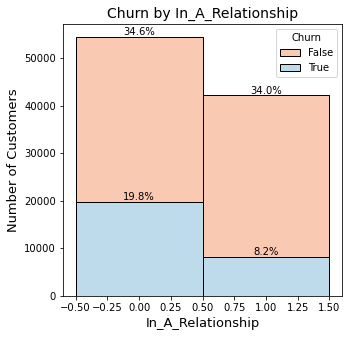

In [25]:
def In_A_Relationship(df):
    if df['marital_status'] == 'Married' or df['marital_status'] == 'Partner':
        return True
    elif df['marital_status'] == 'Divorced' or df['marital_status'] == 'Seperated' or df['marital_status'] == 'Single' or df['marital_status'] == 'Widow':
        return False
df['In_A_Relationship'] = df.apply(In_A_Relationship, axis = 1)
plotdrawing('In_A_Relationship',5, 5)

In [26]:
percentsum('In_A_Relationship')

,TotalCustumers,ChurnQuantity,ChurnRate
In_A_Relationship,,,
False,54444,19801,0.363695
True,42164,8188,0.194194


#### <u>Comment</u>: 
It can be observed from the graph that <b> customers who are not in a relationship are more likely to churn. </b>

#### 3.2.2. Age.

Text(0.5, 1.0, 'Number of customers by age')

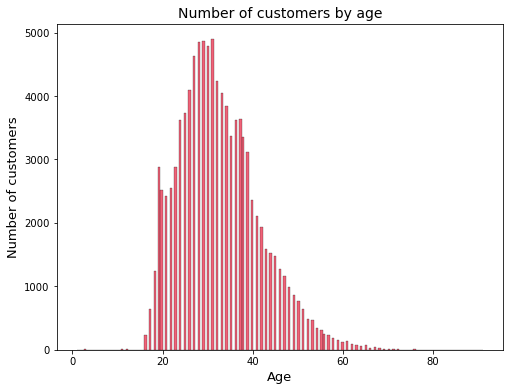

In [27]:
plt.figure(figsize=(8, 6))
age_plt = sns.histplot(data = df[df['age'] <= 100]['age'], color = '#eb2d4b') 
age_plt.set_ylabel('Number of customers', fontsize = 13)
age_plt.set_xlabel('Age', fontsize = 13)
age_plt.set_title('Number of customers by age', fontsize = 14)

#### <u>Comment</u>: 
The customers using bank services are mostly young people, the highest number of customers is in the age of 30. 

We will divide the age into 4 main groups (Students, Adults, Middle-Aged, The Elderly) to see the impact with Churn:

Adults                0.676210
Middle-Aged People    0.191267
Students              0.124990
The Elderly           0.007533
Name: Age Group, dtype: float64


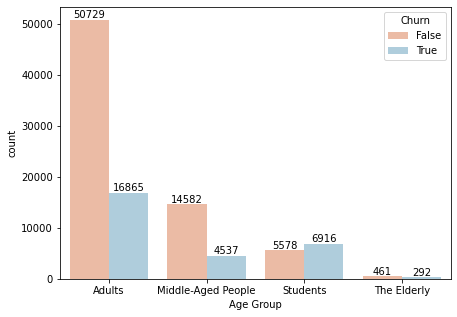

In [28]:
def ages(df):
    if (16 <= df['age'] <= 22) :
        return 'Students'
    elif (23 <= df['age'] <= 39):
        return 'Adults'
    elif (40 <= df['age'] <= 59):
        return 'Middle-Aged People'
    elif (60 <= df['age']): 
        return 'The Elderly'
df['Age Group'] = df.apply(ages, axis = 1)
pdraw('Age Group',7,5)

In [29]:
percentsum('Age Group')

,TotalCustumers,ChurnQuantity,ChurnRate
Age Group,,,
Adults,67594,16865,0.249504
Middle-Aged People,19119,4537,0.237303
Students,12494,6916,0.553546
The Elderly,753,292,0.387782


#### <u>Comment</u>:
- Students group has not too many people (3rd in total number) but constitutes the highest Churn rate, up to more than 50%.
- The Elderly group has the second highest percentage of Churn with the least total number of people in all 4 groups.
- Adults (accounting for nearly 70% of the total number of people) and Middle-aged people have quite similar proportions of Churn.<br>
=> Therefore, age group could be a potential feature to predict churned customers.

#### 3.2.3. Churn by region. 

Source: 'https://danhmuchanhchinh.gso.gov.vn/'

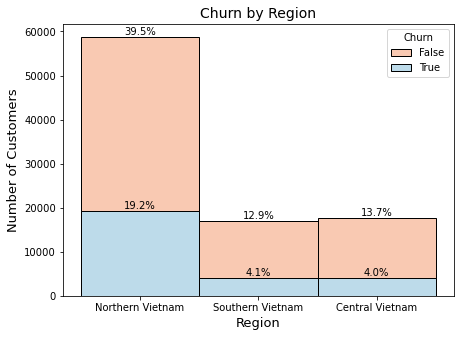

In [30]:
def resid_province(df):
    if (1 <= df['resid_province'] <= 37 ) :
        return 'Northern Vietnam'
    elif (38 <= df['resid_province'] <= 68):
        return 'Central Vietnam'
    elif (70 <= df['resid_province'] <= 96):
        return 'Southern Vietnam'
df['Region'] = df.apply(resid_province, axis = 1)
plotdrawing('Region',7,5)

In [31]:
percentsum('Region')

,TotalCustumers,ChurnQuantity,ChurnRate
Region,,,
Central Vietnam,17707,4025,0.227311
Northern Vietnam,58752,19220,0.327138
Southern Vietnam,16971,4072,0.239939


#### <u>Comment</u>:
- The chart shows that the number of customers in Northern Vietnam is the largest, the Southern and Central region have a similar ratio. The churn rate in Northern Vietnam is also higher than that of its counterpart, which means citizens in the North of Vietnam are more likely to churn. <br>
- The chart below provides information about the Eco-social region having the highest numbers of customers and churn rate, Red River Delta, which is also in Northern Vietnam.

Red River Delta                    0.529798
North Central and Central Coast    0.159692
Southeast                          0.120903
Northern Midlands and Mountains    0.099037
Mekong River Delta                 0.060741
Central Highlands                  0.029830
Name: Eco_Region, dtype: float64


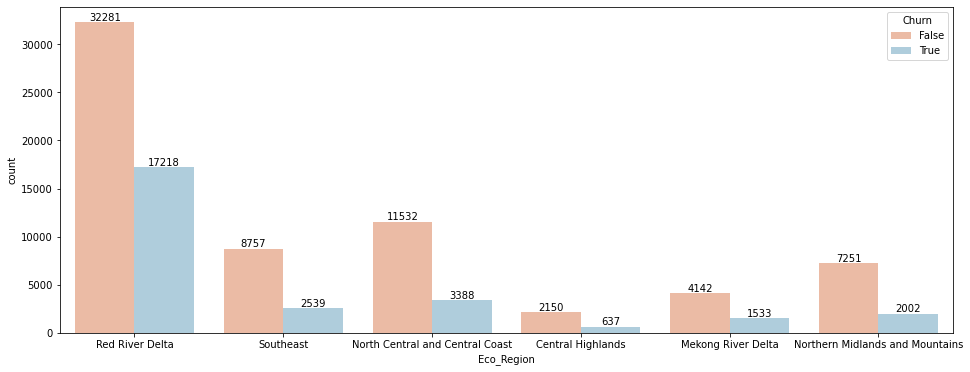

In [32]:
def Eco_Region(df):
    if 2 <= df['resid_province'] < 22 or 23 <= df['resid_province'] <= 25:
        return 'Northern Midlands and Mountains'
    elif df['resid_province'] == 1 or df['resid_province'] == 22 or 26 <= df['resid_province'] <= 37:
        return 'Red River Delta'
    elif 38 <= df['resid_province'] <= 60:
        return 'North Central and Central Coast'
    elif 62 <= df['resid_province'] <= 68:
        return 'Central Highlands'
    elif 70 <= df['resid_province'] <= 79 :
        return 'Southeast'
    elif 80 <= df['resid_province'] <= 96 :
        return 'Mekong River Delta'
df['Eco_Region'] = df.apply(Eco_Region, axis = 1)
pdraw('Eco_Region',16,6)

In [33]:
cond = percentsum('resid_province').index != 0
percentsum('resid_province').loc[cond].sort_values("ChurnRate",ascending=False).head()

,TotalCustumers,ChurnQuantity,ChurnRate
resid_province,,,
1.0,31646,13540,0.427858
83.0,415,166,0.400000
4.0,58,22,0.379310
62.0,74,24,0.324324
12.0,32,10,0.312500


#### <u>Comment</u>: 
Hanoi, Ben Tre, Cao Bang, Kon Tum and Lai Chau are among the cities/provinces with the highest churn rate.

### 3.3. Transaction Information.
#### 3.3.1. Transaction Amount.

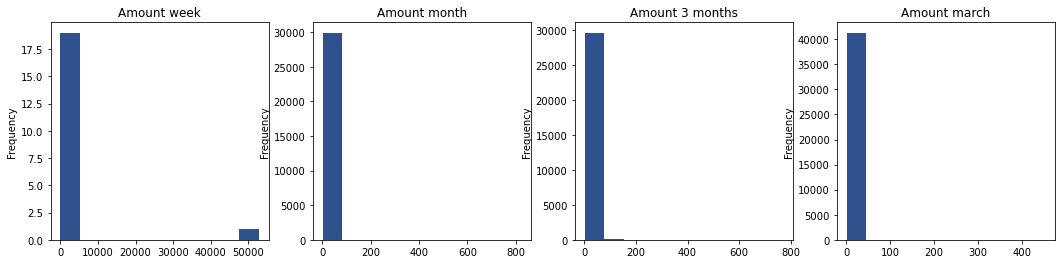

In [34]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, nrows=1, figsize = (18,4))

ax = df['amount_week'].value_counts().sort_index().plot.hist(color = '#2f528f', ax = ax1)
ax1.set_title("Amount week")

ax = df['amount_month'].value_counts().sort_index().plot.hist(color = '#2f528f', ax = ax2)
ax2.set_title("Amount month")

ax = df['amount_3month'].value_counts().sort_index().plot.hist(color = '#2f528f', ax = ax3)
ax3.set_title("Amount 3 months")

ax = df['total_amt_mar2021'].value_counts().sort_index().plot.hist(color = '#2f528f', ax = ax4)
ax4.set_title("Amount march")

plt.show()

It can be seen that the amount of customers' transactions in a week, a month, 3 months and in March is mostly close to 0 and lower than 1.

#### 3.2. Churn by Payment Code

Text(0.5, 1.0, 'Churn by Payment Code 3 Months')

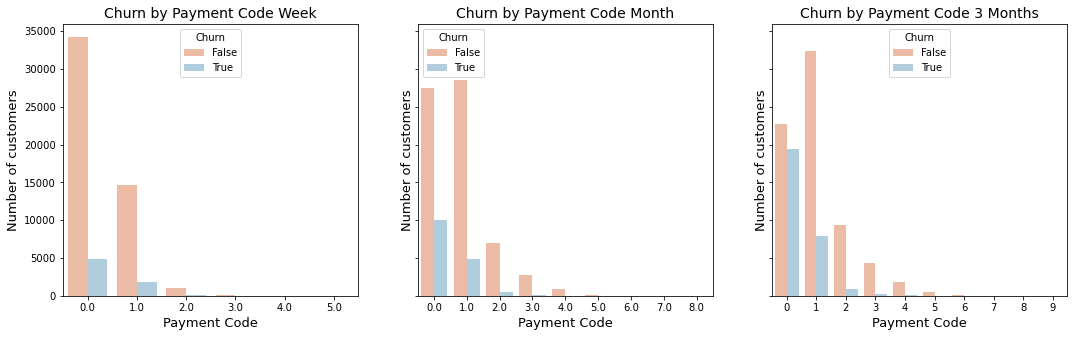

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (18, 5))

ax = sns.countplot(x='distinct_payment_code_week', hue='Churn', data=df, palette='RdBu', ax=ax1)
ax.set_ylabel('Number of customers', fontsize = 13)
ax.set_xlabel('Payment Code', fontsize=13)
ax.set_title('Churn by Payment Code Week', fontsize = 14)

ax = sns.countplot(x='distinct_payment_code_month', hue='Churn', data=df, palette='RdBu', ax=ax2)
ax.set_ylabel('Number of customers', fontsize = 13)
ax.set_xlabel('Payment Code', fontsize=13)
ax.set_title('Churn by Payment Code Month', fontsize = 14)

ax = sns.countplot(x='distinct_payment_code_3month', hue='Churn', data=df, palette='RdBu', ax=ax3)
ax.set_ylabel('Number of customers', fontsize = 13)
ax.set_xlabel('Payment Code',fontsize = 13)
ax.set_title('Churn by Payment Code 3 Months', fontsize = 14)

#### <u>Comment</u>: 
We can see that payment code 0 has the highest churn ratio, followed by payment code number 1 and 2. This is true for transactions in the last 1 week, 1 month and the last 3 months of 2020.

Text(0.5, 1.0, 'Churn by Transaction Group 3 Months')

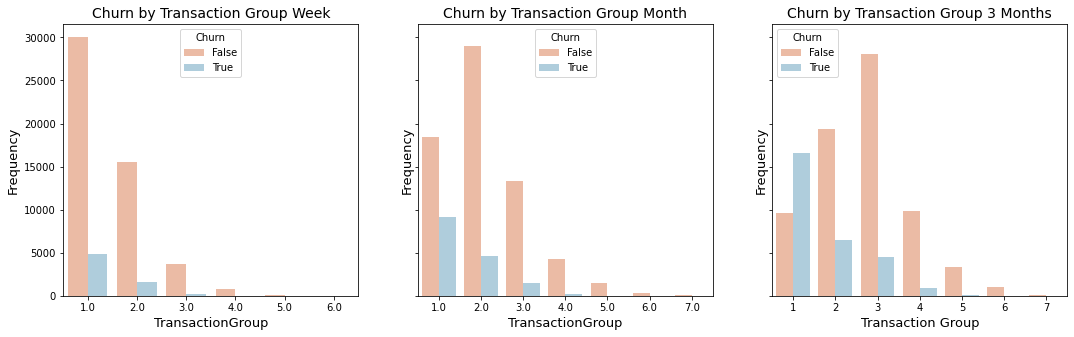

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (18, 5))

ax = sns.countplot(x='distinct_trans_group_week', hue='Churn', data=df, palette='RdBu', ax=ax1)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_xlabel('TransactionGroup', fontsize=13)
ax.set_title('Churn by Transaction Group Week', fontsize = 14)

ax = sns.countplot(x='distinct_trans_group_month', hue='Churn', data=df, palette='RdBu', ax=ax2)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_xlabel('TransactionGroup', fontsize=13)
ax.set_title('Churn by Transaction Group Month', fontsize = 14)

ax = sns.countplot(x='distinct_trans_group_3month', hue='Churn', data=df, palette='RdBu', ax=ax3)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_xlabel('Transaction Group',fontsize = 13)
ax.set_title('Churn by Transaction Group 3 Months', fontsize = 14)

#### <u>Comment</u>: 
The chart illustrates that customers using transaction group 1 has the highest probability to churn. The churn rate decreases gradually in order of the transaction group.

Giao dich chuyen khoan     0.816362
Giao dich thanh toan       0.148566
Giao dich phi tai chinh    0.023436
Giao dich tiet kiem        0.005866
Giao dich rut tien ATM     0.005771
Name: most_act_mar2021, dtype: float64


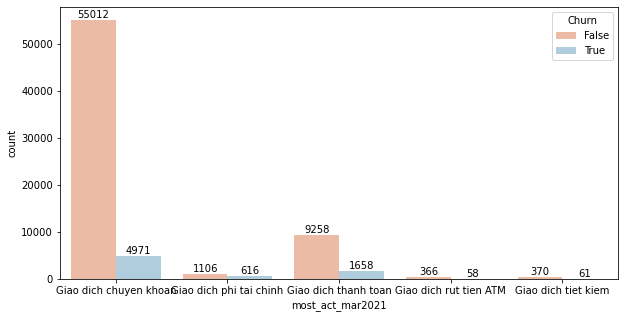

In [37]:
pdraw('most_act_mar2021',10,5)

In [38]:
percentsum('most_act_mar2021')

,TotalCustumers,ChurnQuantity,ChurnRate
most_act_mar2021,,,
Giao dich chuyen khoan,59983,4971,0.082873
Giao dich phi tai chinh,1722,616,0.357724
Giao dich rut tien ATM,424,58,0.136792
Giao dich thanh toan,10916,1658,0.151887
Giao dich tiet kiem,431,61,0.141531


#### <u>Comment</u>: 
- In March 2021, 'Giao dich chuyen khoan' are the most used transaction, and this is also the type of transaction that most customers leave. 
- However, 'Giao dich phi tai chinh', with a small number of customers, is the type with the highest churn rate.

## 4. Model Development <a class="anchor" id="chapter4"></a>

### 4.1. Preprocessing

#### Remove outliers

##### Remove customers who have resid_province = 0

In [39]:
df.drop(df[(df['resid_province'] == 0)].index, inplace = True)
df = df.reset_index(drop= True)

##### Remove customers whose age > 100 or age < 16

<AxesSubplot:ylabel='age'>

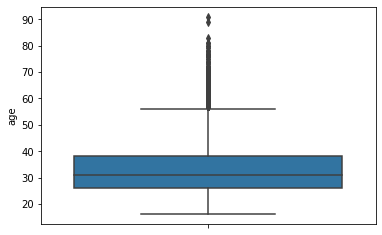

In [40]:
df.drop(df[(df['age'] > 100) | (df['age'] < 16)].index, inplace = True)
df = df.reset_index(drop= True)
sns.boxplot(y = 'age', data = df)

The number of "extreme outliers" have been reduced to a considerable amount.

#### Missing values Handling.

In [41]:
df.isna().sum()

gender                           2730
marital_status                   3023
resid_province                   6556
resid_district                   6552
resid_wards                      6554
amount_week                     45184
max_amount_week                 45184
min_amount_week                 45184
distinct_payment_code_week      43134
count_payment_code_week         43134
distinct_trans_group_week       43134
distinct_ref_no_week            43134
amount_month                    22991
max_amount_month                22991
min_amount_month                22991
distinct_payment_code_month     17769
count_payment_code_month        17769
distinct_trans_group_month      17769
distinct_ref_no_month           17769
amount_3month                   13475
max_amount_3month               13475
min_amount_3month               13475
distinct_payment_code_3month        0
count_payment_code_3month           0
distinct_trans_group_3month         0
distinct_ref_no_3month              0
most_act_mar

In [42]:
df['total_act_mar2021'] = df['total_act_mar2021'].fillna(0)
conditions = [
    (df['total_act_mar2021'] >= 1),
    (df['total_act_mar2021'] == 0)
    ]
values = [0, 1]
df['Trans_In_March'] = np.select(conditions, values)

In [43]:
import copy
df_copy = copy.deepcopy(df)

In [44]:
df_copy['gender'] = df_copy['gender'].fillna('Male')
df_copy['In_A_Relationship'] = df_copy['In_A_Relationship'].fillna(False)
df_copy['Age Group'] = df_copy['Age Group'].fillna('Adults')
df_copy['Region'] = df_copy['Region'].fillna('Northern Vietnam')
df_copy['Eco_Region'] = df_copy['Eco_Region'].fillna('Red River Delta')
df_copy[['amount_week', 'max_amount_week', 'min_amount_week','distinct_payment_code_week', 'count_payment_code_week']] = df_copy[['amount_week', 'max_amount_week', 'min_amount_week','distinct_payment_code_week', 'count_payment_code_week']].fillna(0)
df_copy[['distinct_trans_group_week', 'distinct_ref_no_week']] = df_copy[['distinct_trans_group_week', 'distinct_ref_no_week']].fillna(1)
df_copy[['amount_month', 'max_amount_month', 'min_amount_month','distinct_payment_code_month', 'count_payment_code_month', 'amount_3month', 'max_amount_3month', 'min_amount_3month']] = df_copy[['amount_month', 'max_amount_month', 'min_amount_month','distinct_payment_code_month', 'count_payment_code_month', 'amount_3month', 'max_amount_3month', 'min_amount_3month']].fillna(0)
df_copy[['distinct_trans_group_month', 'distinct_ref_no_month']] = df_copy[['distinct_trans_group_month', 'distinct_ref_no_month']].fillna(1)
df_copy[['most_act_mar2021_count','total_act_mar2021', 'total_amt_mar2021']] = df_copy[['most_act_mar2021_count', 'total_act_mar2021', 'total_amt_mar2021']].fillna(0)
df_copy['most_act_mar2021'] = df_copy['most_act_mar2021'].fillna('No')

df_copy.reset_index(drop=True, inplace=True)

In [45]:
df_copy.drop(['marital_status', 'resid_province', 'resid_district','resid_wards', 'age','most_act_juin2021_count','most_act_juin2021', 'total_act_juin2021', 'total_amt_juin2021','Eco_Region'], inplace = True, axis = 1)

In [46]:
df_copy.isna().sum()

gender                          0
amount_week                     0
max_amount_week                 0
min_amount_week                 0
distinct_payment_code_week      0
count_payment_code_week         0
distinct_trans_group_week       0
distinct_ref_no_week            0
amount_month                    0
max_amount_month                0
min_amount_month                0
distinct_payment_code_month     0
count_payment_code_month        0
distinct_trans_group_month      0
distinct_ref_no_month           0
amount_3month                   0
max_amount_3month               0
min_amount_3month               0
distinct_payment_code_3month    0
count_payment_code_3month       0
distinct_trans_group_3month     0
distinct_ref_no_3month          0
most_act_mar2021_count          0
most_act_mar2021                0
total_act_mar2021               0
total_amt_mar2021               0
Churn                           0
In_A_Relationship               0
Age Group                       0
Region        

#### Transform categorical variables into columns with binary values 0, 1

In [47]:
df_copy['Churn'].replace(to_replace=True, value=1, inplace=True)
df_copy['Churn'].replace(to_replace=False,  value=0, inplace=True)

In [48]:
encoder = OneHotEncoder(drop='if_binary', sparse=False)
dic1 = encoder.fit_transform(df_copy[['gender', 'most_act_mar2021', 'In_A_Relationship', 'Age Group', 'Region']])

In [49]:
lst = encoder.get_feature_names_out(['gender', 'most_act_mar2021', 'In_A_Relationship', 'Age Group', 'Region']) 
out = pd.DataFrame(dic1, columns=lst)
out.head()

,gender_Male,most_act_mar2021_Giao dich chuyen khoan,most_act_mar2021_Giao dich phi tai chinh,most_act_mar2021_Giao dich rut tien ATM,most_act_mar2021_Giao dich thanh toan,most_act_mar2021_Giao dich tiet kiem,most_act_mar2021_No,In_A_Relationship_True,Age Group_Adults,Age Group_Middle-Aged People,Age Group_Students,Age Group_The Elderly,Region_Central Vietnam,Region_Northern Vietnam,Region_Southern Vietnam
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [50]:
df_dummies = pd.concat([df_copy, out], axis=1)
df_dummies.head()

,gender,amount_week,max_amount_week,min_amount_week,distinct_payment_code_week,count_payment_code_week,distinct_trans_group_week,distinct_ref_no_week,amount_month,max_amount_month,min_amount_month,distinct_payment_code_month,count_payment_code_month,distinct_trans_group_month,distinct_ref_no_month,amount_3month,max_amount_3month,min_amount_3month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,distinct_ref_no_3month,most_act_mar2021_count,most_act_mar2021,total_act_mar2021,total_amt_mar2021,Churn,In_A_Relationship,Age Group,Region,Trans_In_March,gender_Male,most_act_mar2021_Giao dich chuyen khoan,most_act_mar2021_Giao dich phi tai chinh,most_act_mar2021_Giao dich rut tien ATM,most_act_mar2021_Giao dich thanh toan,most_act_mar2021_Giao dich tiet kiem,most_act_mar2021_No,In_A_Relationship_True,Age Group_Adults,Age Group_Middle-Aged People,Age Group_Students,Age Group_The Elderly,Region_Central Vietnam,Region_Northern Vietnam,Region_Southern Vietnam
0,Male,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000056,0.000204,0.000008,0.0,0.0,2.0,12.0,0.000073,0.000400,5.920000e-06,0,0,2,33,5.0,Giao dich chuyen khoan,5.0,0.000016,0,True,Adults,Northern Vietnam,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Male,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000019,0.000140,0.000203,0.0,0.0,1.0,1.0,0.000014,0.000068,1.103180e-04,0,0,2,5,0.0,No,0.0,0.000000,0,False,Adults,Southern Vietnam,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Male,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000030,0.000122,0.000143,0.0,0.0,1.0,2.0,0.000016,0.000060,2.100000e-05,2,3,2,7,4.0,Giao dich chuyen khoan,6.0,0.000046,0,True,Middle-Aged People,Northern Vietnam,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,Male,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000e+00,0,0,1,1,0.0,No,0.0,0.000000,1,False,Students,Central Vietnam,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,Male,0.0,0.000114,0.000636,0.0,0.0,1.0,1.0,0.000097,0.000247,0.000001,1.0,5.0,3.0,12.0,0.000074,0.000380,5.920000e-07,1,11,3,24,9.0,Giao dich chuyen khoan,10.0,0.000170,0,True,Adults,Central Vietnam,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Removal of unnecessary variables

In [51]:
df_dummies.drop(['gender', 'most_act_mar2021', 'In_A_Relationship', 'Age Group', 'Region'], inplace = True, axis = 1)

In [52]:
df_dummies

,amount_week,max_amount_week,min_amount_week,distinct_payment_code_week,count_payment_code_week,distinct_trans_group_week,distinct_ref_no_week,amount_month,max_amount_month,min_amount_month,distinct_payment_code_month,count_payment_code_month,distinct_trans_group_month,distinct_ref_no_month,amount_3month,max_amount_3month,min_amount_3month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,distinct_ref_no_3month,most_act_mar2021_count,total_act_mar2021,total_amt_mar2021,Churn,Trans_In_March,gender_Male,most_act_mar2021_Giao dich chuyen khoan,most_act_mar2021_Giao dich phi tai chinh,most_act_mar2021_Giao dich rut tien ATM,most_act_mar2021_Giao dich thanh toan,most_act_mar2021_Giao dich tiet kiem,most_act_mar2021_No,In_A_Relationship_True,Age Group_Adults,Age Group_Middle-Aged People,Age Group_Students,Age Group_The Elderly,Region_Central Vietnam,Region_Northern Vietnam,Region_Southern Vietnam
0,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000056,0.000204,0.000008,0.0,0.0,2.0,12.0,0.000073,0.000400,5.920000e-06,0,0,2,33,5.0,5.0,0.000016,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000019,0.000140,0.000203,0.0,0.0,1.0,1.0,0.000014,0.000068,1.103180e-04,0,0,2,5,0.0,0.0,0.000000,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000030,0.000122,0.000143,0.0,0.0,1.0,2.0,0.000016,0.000060,2.100000e-05,2,3,2,7,4.0,6.0,0.000046,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000e+00,0,0,1,1,0.0,0.0,0.000000,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.000114,0.000636,0.0,0.0,1.0,1.0,0.000097,0.000247,0.000001,1.0,5.0,3.0,12.0,0.000074,0.000380,5.920000e-07,1,11,3,24,9.0,10.0,0.000170,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99959,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000e+00,0,0,1,2,16.0,18.0,0.000108,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99960,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000e+00,0,0,1,1,0.0,0.0,0.000000,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
99961,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000046,0.000333,0.000482,0.0,0.0,2.0,2.0,0.000012,0.000163,5.150000e-05,0,0,2,4,5.0,9.0,0.000436,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
99962,0.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000e+00,0,0,1,1,29.0,36.0,0.000090,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 4.2. Model Building

In [53]:
def metrics_scoring_table(y_model,y_true, y_proba, model_name):
    prec = precision_score(y_true, y_model)
    accu = accuracy_score( y_true, y_model)
    recall = recall_score(y_true, y_model)
    f1 = f1_score(y_true, y_model)
    roc = roc_auc_score(y_true, y_proba[:, 1])
    df_score = pd.DataFrame(data= {
    "model" :  model_name,
    "accuracy score": accu,
    "precision score": prec,
    "recall score": recall,
    "f1-score": f1,
    "ROC-AUC": roc
    },
    index = [0]
    )
    return df_score

In [54]:
def roc_curve_plot(Y_pred, Y_true, Y_pred_pobablities, model_name):
    Y_pp = Y_pred_pobablities[:, 1]
    fpr, tpr, threshold1 = roc_curve(Y_true, Y_pp )
    
    fig, ax = plt.subplots(nrows=1, ncols= 1, figsize = (7,5), constrained_layout = True)
    ax.plot(fpr, tpr, label='ROC Score: {:.5f}'.format(roc_auc_score(Y_true, Y_pp)))
    ax.set_title(f"{model_name} ROC Curve ", fontdict = {"fontsize": 18})
    ax.set_xlabel("False Positive Rate", fontdict = {"fontsize": 15} )
    ax.set_ylabel("True Positive Rate", fontdict = {"fontsize": 15})
    ax.legend(loc = 4, fontsize = 14 )

    plt.show()
    

In [55]:
def roc_summary_plot(Y_true, Y_probability = [], model_name = []):
    for i in range(len(Y_probability)):
        
        fpr, tpr, threshold1 = roc_curve(Y_true,Y_probability[i][:,1] )
        plt.style.use("seaborn-white")
        plt.figure( num = 1, figsize = (12, 9))
        plt.title("ROC scores summary (tuned model)", fontsize = 18)
        plt.xlabel("False Positive Rate" , fontdict = {"fontsize": 15})
        plt.ylabel("True Positive Rate" , fontdict = {"fontsize": 15})
        plt.plot(fpr, tpr, label='{0} ROC Score: {1}'.format(model_name[i] ,round(roc_auc_score(Y_true, Y_probability[i][:,1] ) ,2)))
        plt.legend(loc = 4, fontsize =13)
    plt.show()

In [56]:
X = df_dummies.drop('Churn', axis=1)
Y = df_dummies['Churn']

#### Splitting the dataset into the Training set and Test set.

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)

#### Oversampling.

In [58]:
SM = SMOTE(sampling_strategy = 1, k_neighbors= 5)

In [59]:
X_train, Y_train = SM.fit_resample(X_train, Y_train)

#### Multicollinearity Detecting for Logistic Model.

<AxesSubplot:>

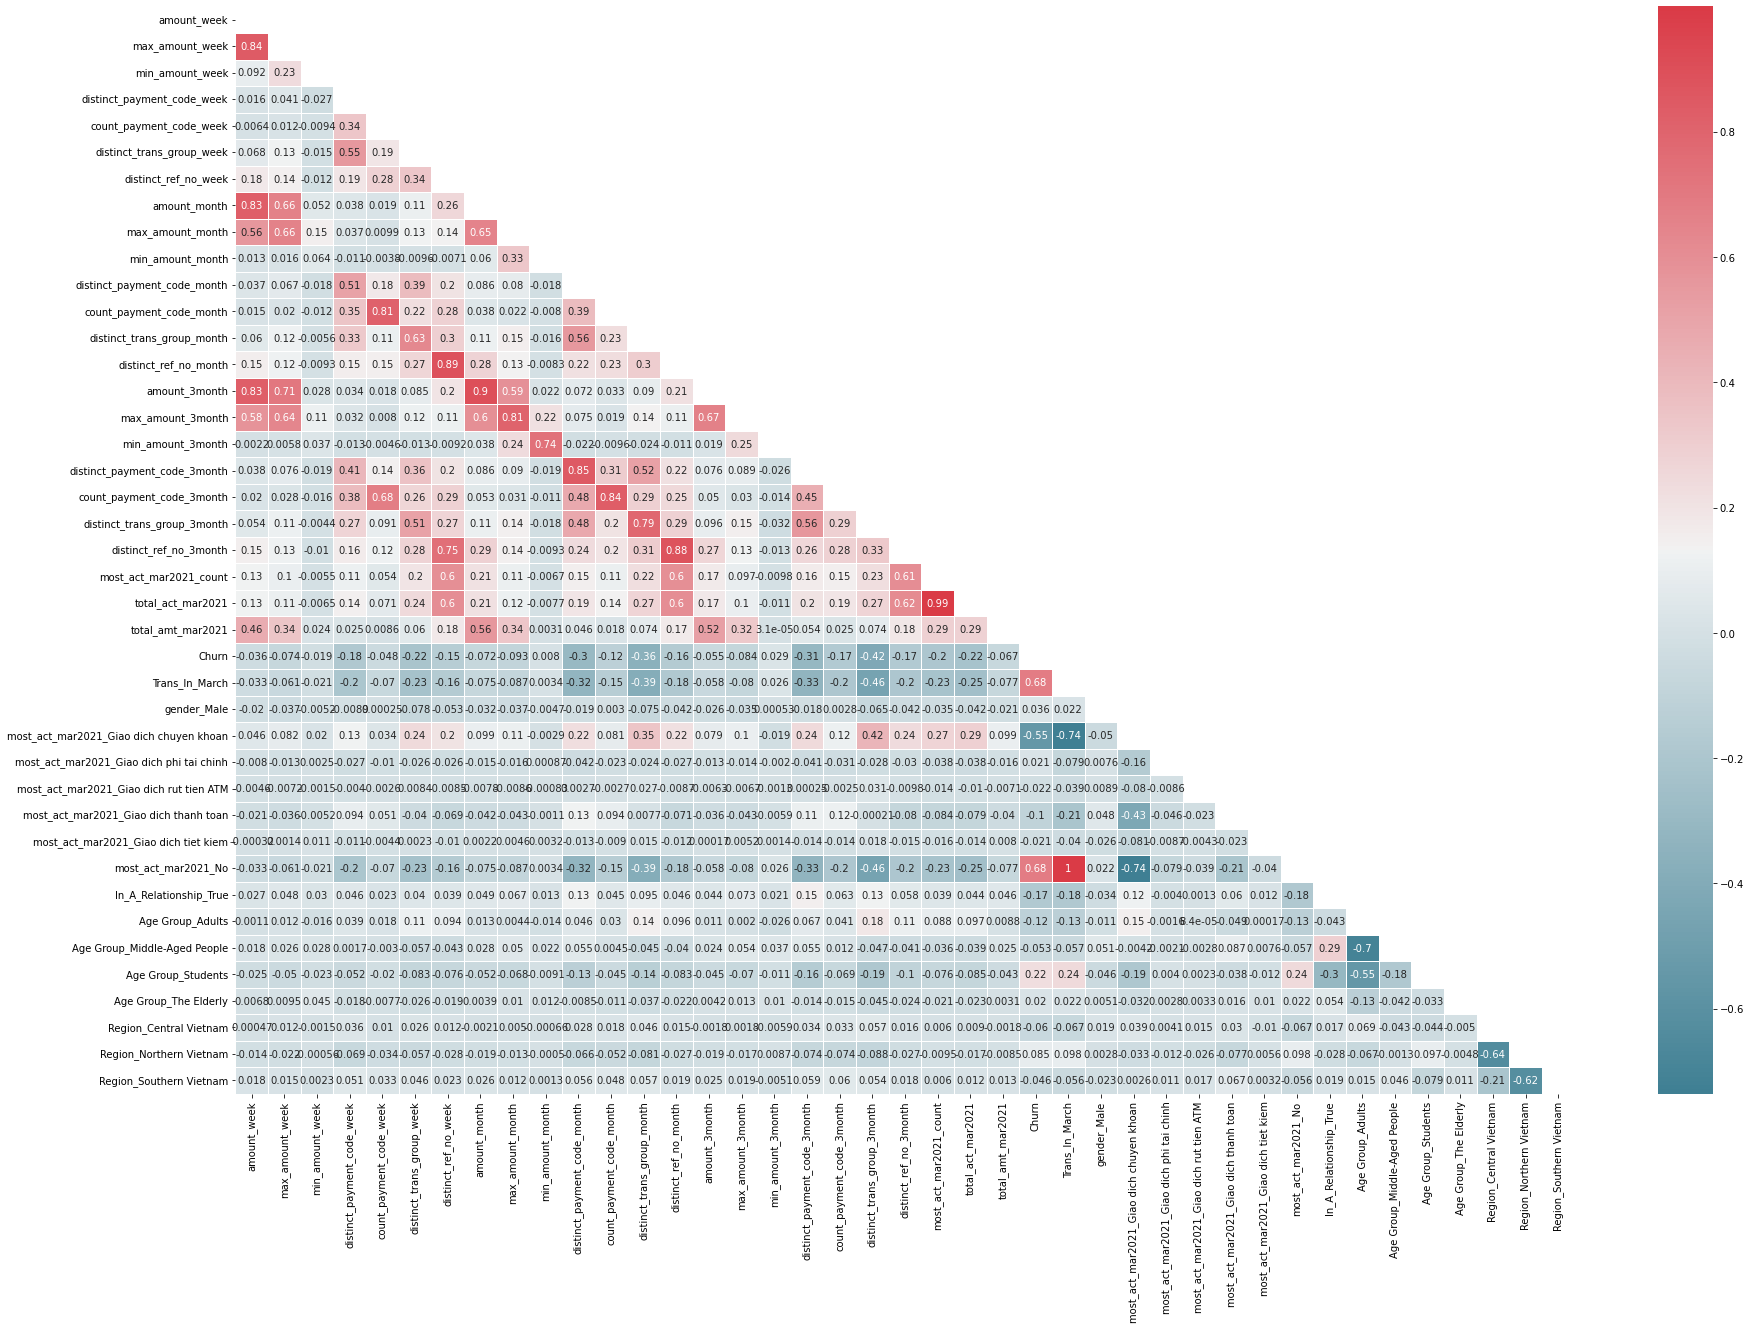

In [60]:
fig, ax = plt.subplots(figsize=(30, 20))
corr = df_dummies.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot = True, linewidth=.8, cmap=cmap, mask=mask)

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_check = df_dummies.drop('Churn', axis=1)

vif_results = pd.DataFrame()
vif_results['Feature'] = vif_check.columns

vif_results['VIF'] = [variance_inflation_factor(vif_check.values, i) for i in range(len(vif_check.columns))]
vif_results.sort_values(by = 'VIF', ascending=False)
cond = vif_results['VIF'] <= 10
vif_results.loc[cond]

,Feature,VIF
0,amount_week,8.037315
1,max_amount_week,5.845362
2,min_amount_week,1.140529
3,distinct_payment_code_week,1.988188
4,count_payment_code_week,3.893595
5,distinct_trans_group_week,2.468850
6,distinct_ref_no_week,6.464196
8,max_amount_month,5.381405
9,min_amount_month,2.584801
10,distinct_payment_code_month,5.024367


In [62]:
cond = vif_results['VIF'] <= 10
vif_results.loc[cond]['Feature'].tolist()

['amount_week',
 'max_amount_week',
 'min_amount_week',
 'distinct_payment_code_week',
 'count_payment_code_week',
 'distinct_trans_group_week',
 'distinct_ref_no_week',
 'max_amount_month',
 'min_amount_month',
 'distinct_payment_code_month',
 'count_payment_code_month',
 'distinct_trans_group_month',
 'amount_3month',
 'max_amount_3month',
 'min_amount_3month',
 'distinct_payment_code_3month',
 'count_payment_code_3month',
 'distinct_trans_group_3month',
 'distinct_ref_no_3month',
 'total_amt_mar2021',
 'gender_Male',
 'In_A_Relationship_True']

#### 4.2.1. Logistic Regression

In [63]:
feature_sc = vif_results.loc[cond]['Feature'].tolist()

In [64]:
X_train_log = copy.deepcopy(X_train)
X_test_log = copy.deepcopy(X_test)

In [65]:
sc = StandardScaler()

X_train_log[feature_sc] = sc.fit_transform(X_train_log[feature_sc])
X_test_log[feature_sc] = sc.transform(X_test_log[feature_sc])

In [66]:
logr = LogisticRegression(max_iter= 1000)
logr.fit(X_train_log[feature_sc], Y_train)

logr_Y_pred = logr.predict(X_test_log[feature_sc])
logr_Y_proba = logr.predict_proba(X_test_log[feature_sc])

In [67]:
metrics_scoring_table(logr_Y_pred,Y_test, logr_Y_proba, "LogisticRegression")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,LogisticRegression,0.736258,0.526902,0.768438,0.625151,0.822155


In [68]:
print(classification_report(Y_test, logr_Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80     14271
           1       0.53      0.77      0.63      5722

    accuracy                           0.74     19993
   macro avg       0.71      0.75      0.71     19993
weighted avg       0.78      0.74      0.75     19993



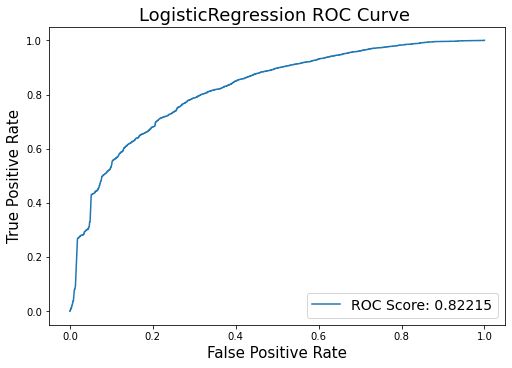

In [69]:
roc_curve_plot(logr_Y_pred ,Y_test, logr_Y_proba, "LogisticRegression")

#### 4.2.2. K Nearest Neighbors

In [70]:
X_train_knn = copy.deepcopy(X_train)
X_test_knn = copy.deepcopy(X_test)

In [71]:
sc = StandardScaler()

X_train_knn[feature_sc] = sc.fit_transform(X_train_knn[feature_sc])
X_test_knn[feature_sc] = sc.transform(X_test_knn[feature_sc])

In [72]:
knn = KNeighborsClassifier(n_neighbors= 5 , p = 2)
knn.fit(X_train_knn[feature_sc], Y_train)

knn_Y_pred = knn.predict(X_test_knn[feature_sc])
knn_Y_proba = knn.predict_proba(X_test_knn[feature_sc])

In [73]:
metrics_scoring_table(knn_Y_pred,Y_test, knn_Y_proba, "KNearestNeighbors")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,KNearestNeighbors,0.822938,0.670736,0.749039,0.707728,0.862122


In [74]:
print(classification_report(Y_test, knn_Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     14271
           1       0.67      0.75      0.71      5722

    accuracy                           0.82     19993
   macro avg       0.78      0.80      0.79     19993
weighted avg       0.83      0.82      0.83     19993



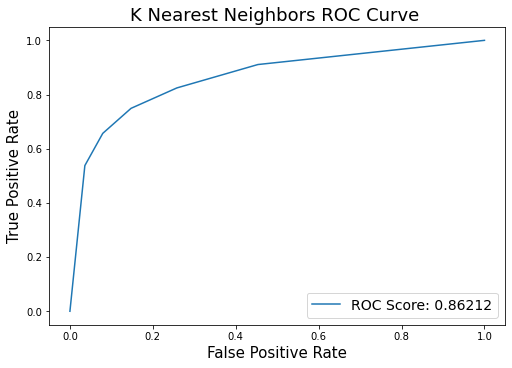

In [75]:
roc_curve_plot(knn_Y_pred ,Y_test, knn_Y_proba, "K Nearest Neighbors")

#### 4.2.3. Decision Tree Classifier

In [76]:
dt = DecisionTreeClassifier()

dt.fit(X_train, Y_train)

dt_Y_pred = dt.predict(X_test)
dt_Y_proba = dt.predict_proba(X_test)

In [77]:
metrics_scoring_table(dt_Y_pred,Y_test, dt_Y_proba, "Decision Tree")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,Decision Tree,0.852398,0.719468,0.793778,0.754799,0.819419


In [78]:
print(classification_report(Y_test, dt_Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     14271
           1       0.72      0.79      0.75      5722

    accuracy                           0.85     19993
   macro avg       0.82      0.83      0.82     19993
weighted avg       0.86      0.85      0.85     19993



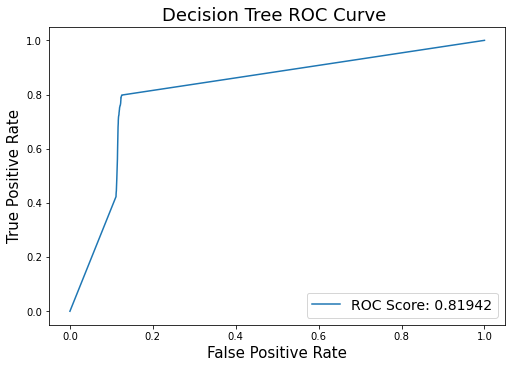

In [79]:
roc_curve_plot(dt_Y_pred ,Y_test, dt_Y_proba, "Decision Tree")

#### 4.2.4. Random Forest

In [80]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 2)

rf.fit(X_train, Y_train)

rf_Y_pred = rf.predict(X_test)
rf_Y_proba = rf.predict_proba(X_test)

In [81]:
metrics_scoring_table(rf_Y_pred,Y_test, rf_Y_proba, "RandomForest")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,RandomForest,0.899115,0.823129,0.824712,0.82392,0.943174


In [82]:
print(classification_report(Y_test, rf_Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     14271
           1       0.82      0.82      0.82      5722

    accuracy                           0.90     19993
   macro avg       0.88      0.88      0.88     19993
weighted avg       0.90      0.90      0.90     19993



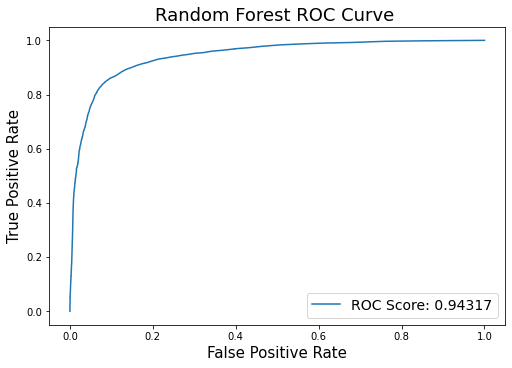

In [83]:
roc_curve_plot(rf_Y_pred ,Y_test, rf_Y_proba, "Random Forest")

#### 4.2.5. XGB Classifier

In [84]:
XGB = XGBClassifier()

XGB.fit(X_train, Y_train)

XGB_Y_pred = XGB.predict(X_test)
XGB_Y_proba = XGB.predict_proba(X_test)

In [85]:
metrics_scoring_table(XGB_Y_pred,Y_test, XGB_Y_proba, "XGBClassifier")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,XGBClassifier,0.880208,0.786761,0.797623,0.792155,0.929034


In [86]:
print(classification_report(Y_test, XGB_Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     14271
           1       0.79      0.80      0.79      5722

    accuracy                           0.88     19993
   macro avg       0.85      0.86      0.85     19993
weighted avg       0.88      0.88      0.88     19993



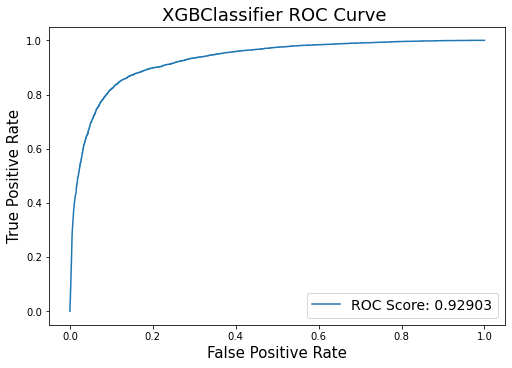

In [87]:
roc_curve_plot(XGB_Y_pred ,Y_test, XGB_Y_proba, "XGBClassifier")

### 4.3. Model Evaluation Summary

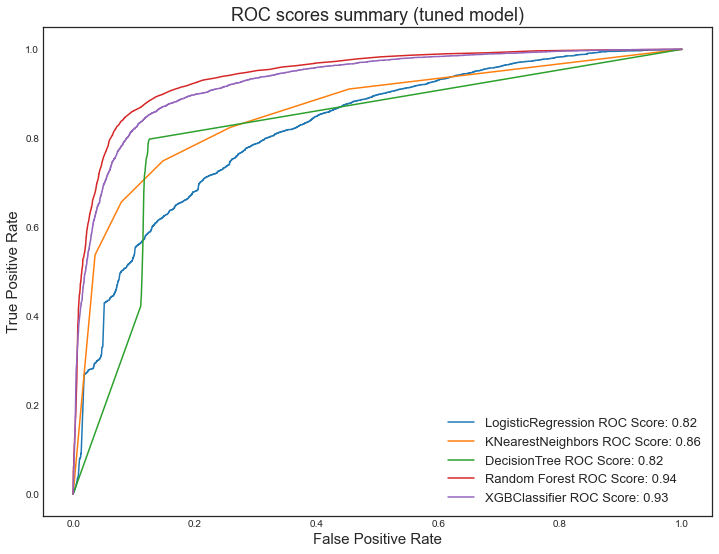

In [88]:
roc_summary_plot(Y_test, [logr_Y_proba, knn_Y_proba, dt_Y_proba, rf_Y_proba, XGB_Y_proba],
                         ["LogisticRegression", "KNearestNeighbors", "DecisionTree" ,"Random Forest", "XGBClassifier"])

In [89]:
score_1 = metrics_scoring_table(logr_Y_pred,Y_test, logr_Y_proba ,"LogisticRegression")
score_2 = metrics_scoring_table(knn_Y_pred,Y_test, knn_Y_proba ,"KNearestNeighbors")
score_3 = metrics_scoring_table(dt_Y_pred,Y_test, dt_Y_proba ,"Decision Tree")
score_4 = metrics_scoring_table(rf_Y_pred,Y_test, rf_Y_proba ,"RandomForest")
score_5 = metrics_scoring_table(XGB_Y_pred,Y_test, XGB_Y_proba ,"XGBClassifier")
score = pd.concat([score_1,score_2,score_3,score_4,score_5], axis=0)
score

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,LogisticRegression,0.736258,0.526902,0.768438,0.625151,0.822155
0,KNearestNeighbors,0.822938,0.670736,0.749039,0.707728,0.862122
0,Decision Tree,0.852398,0.719468,0.793778,0.754799,0.819419
0,RandomForest,0.899115,0.823129,0.824712,0.823920,0.943174
0,XGBClassifier,0.880208,0.786761,0.797623,0.792155,0.929034


#### <u>Comment</u>: 
We chose 2 models which have the highest F1-score and ROC score and continue tuning models: <b>RandomForest</b> and <b>XGBClassifier</b>

## 5. Model Tuning. <a class="anchor" id="chapter5"></a>

### Feature Importance.

[0.00048656 0.0168516  0.01414991 0.00286091 0.00374287 0.00395383
 0.01033664 0.02293423 0.04609436 0.02015883 0.00988063 0.00883178
 0.01979477 0.06292761 0.03466112 0.03899694 0.02684107 0.00582979
 0.01293213 0.02017694 0.04811762 0.09534953 0.1055372  0.04230561
 0.0677838  0.01814494 0.05870596 0.00307568 0.00040727 0.00693712
 0.00049927 0.10799087 0.01657272 0.00855714 0.00653628 0.00587227
 0.00092205 0.0071124  0.0105556  0.0065741 ]


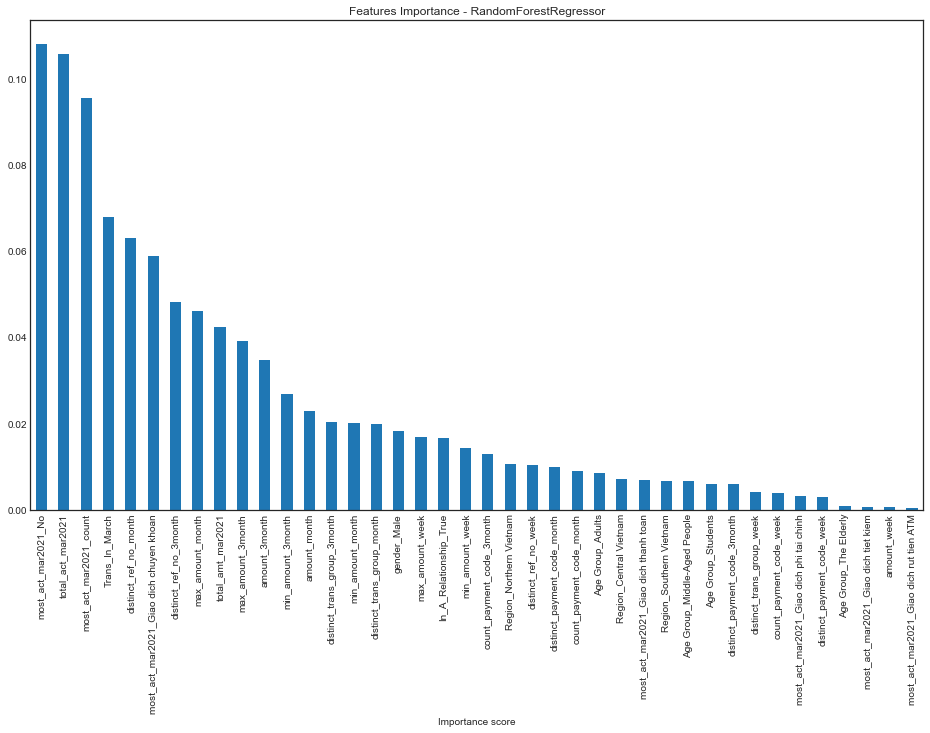

In [90]:
print(rf.feature_importances_) # use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
plt.figure(figsize=(16, 9))
feat_importances.nlargest(len(rf.feature_importances_)).plot(kind='bar')
plt.xlabel('Importance score')
plt.title('Features Importance - RandomForestRegressor')
plt.show()

In [91]:
feat_importances.nlargest(len(rf.feature_importances_)).index[:13]

Index(['most_act_mar2021_No', 'total_act_mar2021', 'most_act_mar2021_count',
       'Trans_In_March', 'distinct_ref_no_month',
       'most_act_mar2021_Giao dich chuyen khoan', 'distinct_ref_no_3month',
       'max_amount_month', 'total_amt_mar2021', 'max_amount_3month',
       'amount_3month', 'min_amount_3month', 'amount_month'],
      dtype='object')

In [92]:
selected_feat = feat_importances.nlargest(len(rf.feature_importances_)).index[:13]

### 5.1. Random Forest.

In [93]:
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [94]:
RF_tuned = RandomForestClassifier()
grid_RF_params = {'n_estimators': np.arange(82, 90, 1), 
                  'criterion' : [ 'entropy'], 
                  'max_depth': np.arange(1,3,1), 
                  'max_features': ['sqrt']}
grid_RF_cv = GridSearchCV(RF_tuned, grid_RF_params, scoring = 'roc_auc', refit = True, cv=CV, verbose=1)  
grid_RF_cv.fit(X_train[selected_feat], Y_train) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': array([1, 2]),
                         'max_features': ['sqrt'],
                         'n_estimators': array([82, 83, 84, 85, 86, 87, 88, 89])},
             scoring='roc_auc', verbose=1)

In [95]:
best_RF = grid_RF_cv.best_estimator_
best_RF.fit(X_train[selected_feat], Y_train)
best_rf_Y_pred = best_RF.predict(X_test[selected_feat])
best_rf_Y_proba = best_RF.predict_proba(X_test[selected_feat])

In [96]:
metrics_scoring_table(best_rf_Y_pred, Y_test, best_rf_Y_proba, "RandomForest")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,RandomForest,0.874156,0.797845,0.750437,0.773415,0.908026


In [97]:
print(classification_report(Y_test, best_rf_Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     14271
           1       0.80      0.75      0.77      5722

    accuracy                           0.87     19993
   macro avg       0.85      0.84      0.84     19993
weighted avg       0.87      0.87      0.87     19993



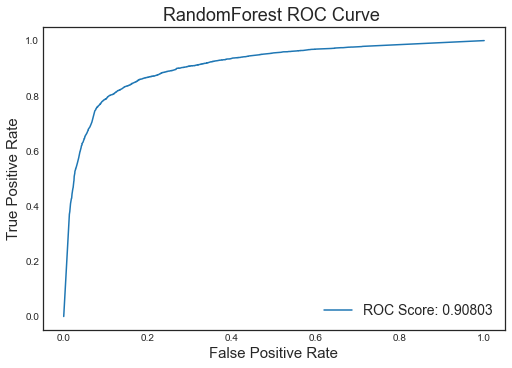

In [98]:
roc_curve_plot(best_rf_Y_pred ,Y_test, best_rf_Y_proba, "RandomForest")

### 5.2. XGB Classifier.

In [99]:
xgb_model = XGBClassifier()
XGB_parameters = {
    'n_estimators': [100, 400],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.20],
    'min_child_weight': [1, 10]
       }
grid_XGB_cv = GridSearchCV(xgb_model, XGB_parameters, cv=CV, scoring='roc_auc', verbose=1 , refit=True)
grid_XGB_cv.fit(X_train[selected_feat], Y_train) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [100]:
best_XGB = grid_XGB_cv.best_estimator_
best_XGB.fit(X_train[selected_feat], Y_train)
best_XGB_Y_pred = best_XGB.predict(X_test[selected_feat])
best_XGB_Y_proba = best_XGB.predict_proba(X_test[selected_feat])

In [101]:
metrics_scoring_table(best_XGB_Y_pred, Y_test, best_XGB_Y_proba, "XGBClassifier")

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,XGBClassifier,0.884159,0.788546,0.813352,0.800757,0.929198


In [102]:
print(classification_report(Y_test, best_XGB_Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     14271
           1       0.79      0.81      0.80      5722

    accuracy                           0.88     19993
   macro avg       0.86      0.86      0.86     19993
weighted avg       0.89      0.88      0.88     19993



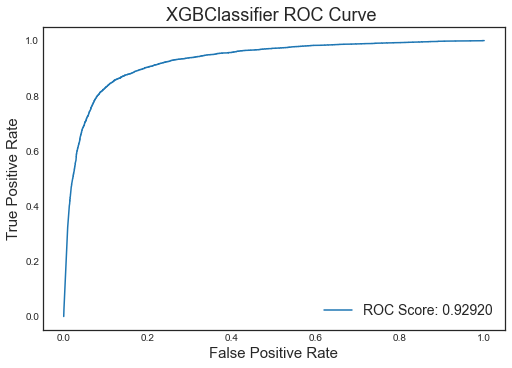

In [103]:
roc_curve_plot(best_XGB_Y_pred ,Y_test, best_XGB_Y_proba, "XGBClassifier")

## 6. Conclusion. <a class="anchor" id="chapter5"></a>

#### Profile customers who are likely to churn: <br> *Male, at the age of 16 to 22, and not In a relationship.*

In [104]:
tune_score_1 = metrics_scoring_table(best_rf_Y_pred, Y_test, best_rf_Y_proba ,"RandomForest")
tune_score_2 = metrics_scoring_table(best_XGB_Y_pred, Y_test, best_XGB_Y_proba ,"XGBClassifier")
tune_score = pd.concat([tune_score_1,tune_score_2], axis=0)
tune_score

,model,accuracy score,precision score,recall score,f1-score,ROC-AUC
0,RandomForest,0.874156,0.797845,0.750437,0.773415,0.908026
0,XGBClassifier,0.884159,0.788546,0.813352,0.800757,0.929198


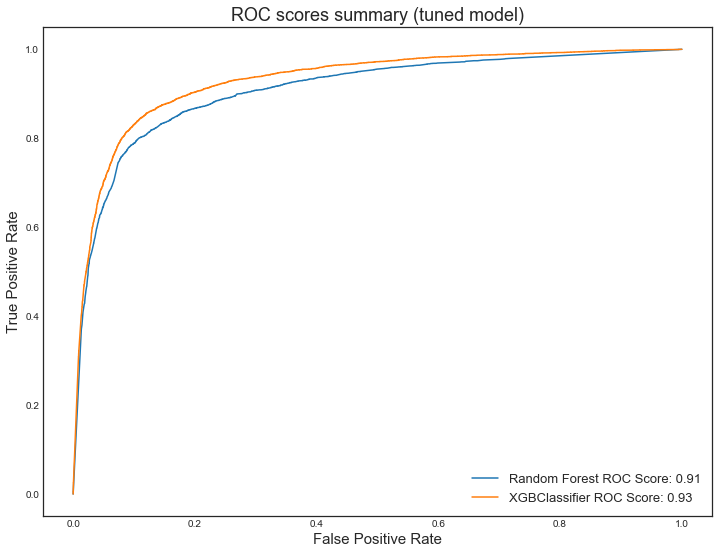

In [105]:
roc_summary_plot(Y_test, [best_rf_Y_proba, best_XGB_Y_proba],
                         ["Random Forest", "XGBClassifier"])

#### <u>Comment</u>: 
- Model XGBClassifier had the highest values of both ROC and F1-score.